# 1. Causal inference demo with Gurobi Machine Learning

This notebook is an exploration of causal inference with [Gurobi Machine Learning](https://gurobi-machinelearning.readthedocs.io/en/stable/).

## What is causal inference?

Causal inference is a subfield of machine learning that seeks to understand the causal relationships between different variables.

It involves identifying the effects of one variable on another and establishing whether a causal relationship exists between them.
Causal inference is crucial in many applications, such as medicine, economics, and social sciences, where we want to determine the impact of an intervention on an outcome of interest.

## What is Gurobi Machine Learning?

[Gurobi Machine Learning](https://gurobi-machinelearning.readthedocs.io/en/stable/) is a Python package to help use trained regression models in mathematical optimization models.

The package supports a variety of models trained by different machine learning frameworks ([scikit-learn](https://scikit-learn.org/stable/), [Keras](https://keras.io/) and [PyTorch](https://pytorch.org/)), but it limits available models.
For example, Logistic Regression is the only one available classifier. See [Supported Regression models](https://gurobi-machinelearning.readthedocs.io/en/stable/mlm-supported.html) for more details.


## What is this dataset?

The dataset comes from [Thornton (2008)](https://www.aeaweb.org/articles?id=10.1257/aer.98.5.1829) evaluating an experiment in which individuals in rural Malawi were randomly assigned monetary incentives to learn their HIV results after being tested.

Here is the definition of the variables.

| column  | definition             |
|---------|------------------------|
| villnum | Village ID             |
| got     | Got HIV results        |
| distvct | Distance in kilometers |
| tinc    | Total incentive        |
| any     | Received any incentive |
| age     | Age                    |
| hiv2004 | HIV results            |

## What is the goal of this notebook?

The integration of mathematical optimization and machine learning can be achieved with [Gurobi Machine Learning](https://gurobi-machinelearning.readthedocs.io/en/stable/).

In this notebook, machine learning is used to predict the influence on the objective variable $y$ ($got$) by the total incentive $x$ ($tinc$) together with other variables ($distvct$ and $age$).
We use mathematical optimization to maximize $y$ given the constraint that the maximal budget for the sum of all incentives is $0.2n$ and each individual can be offered an incentive of $3$ at most.

The prediction function for the probability of $y_i$ can be denoted with $distvct_i$ and $age_i$ as below.

$$
    y_i = f(x_i, distvct_i, age_i)
$$

The full model reads:

$$
    \begin{align}
        \text{maximize} \quad &\sum_{i=0}^{n}y_i \\
        \text{subject to} \quad &\sum_{i=0}^{n}x_i \le 0.2n \\
        &y_i = f(x_i, distvct_i, age_i) \quad i = 1,\dots,n, \\
        &0 \le x \le 3
    \end{align}
$$

We also aim to learn which methods and attributes are accessed in the pipeline during the optimization, in order to understand what is going on behind the scene.

In [1]:
# Import necessary packages
import gurobipy as gp
import gurobipy_pandas as gppd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gurobi_ml import add_predictor_constr
from causaldata import thornton_hiv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# Use the causaldata package to retrieve the data
data = thornton_hiv.load_pandas().data

# Limit the sample size to fit in the Gurobi's free license
data = data.sample(n=1000, ignore_index=True)

data.head()

,villnum,got,distvct,tinc,any,age,hiv2004
0,6.0,NaN,1.580564,NaN,NaN,43.0,NaN
1,106.0,1.0,1.210657,2.83680,1.0,33.0,0.0
2,51.0,0.0,2.234085,0.94560,1.0,54.0,0.0
3,120.0,1.0,1.817547,1.89120,1.0,32.0,0.0
4,60.0,1.0,3.795818,1.98576,1.0,27.0,0.0


In [3]:
# Replace NaN with appropriate values
data = data.fillna({
    'got': 0.0,
    'tinc': 0.0,
    'any': 0.0,
    'age': data['age'].mean(),
})

data.head()

,villnum,got,distvct,tinc,any,age,hiv2004
0,6.0,0.0,1.580564,0.00000,0.0,43.0,NaN
1,106.0,1.0,1.210657,2.83680,1.0,33.0,0.0
2,51.0,0.0,2.234085,0.94560,1.0,54.0,0.0
3,120.0,1.0,1.817547,1.89120,1.0,32.0,0.0
4,60.0,1.0,3.795818,1.98576,1.0,27.0,0.0


In [4]:
# Describe the overview of the data
data.describe()

,villnum,got,distvct,tinc,any,age,hiv2004
count,996.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,606.000000
mean,65.168675,0.422000,1.969748,0.575681,0.453000,33.596472,0.059406
std,48.923524,0.494126,1.229507,0.832288,0.498035,12.243783,0.250162
min,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,-1.000000
25%,12.000000,0.000000,1.026629,0.000000,0.000000,24.000000,0.000000
50%,62.000000,0.000000,1.680716,0.000000,0.000000,33.596472,0.000000
75%,113.000000,1.000000,2.664718,0.945600,1.000000,41.000000,0.000000
max,145.000000,1.000000,5.191559,2.836800,1.000000,84.000000,1.000000


any
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: got, dtype: object

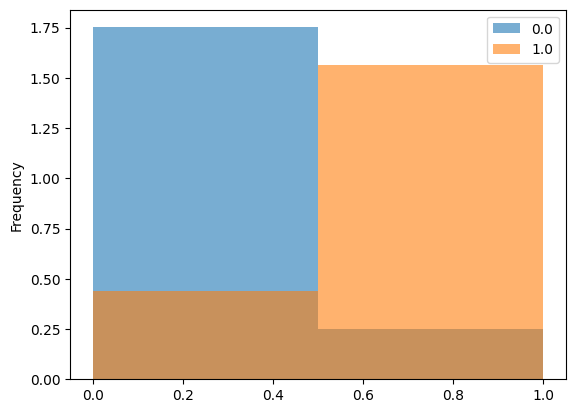

In [5]:
# Individuals offered incentives have higher "got"
data.groupby('any')['got'].plot(
    kind='hist',
    bins=2,
    alpha=0.6,
    density=True,
    legend=True
)

any
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: distvct, dtype: object

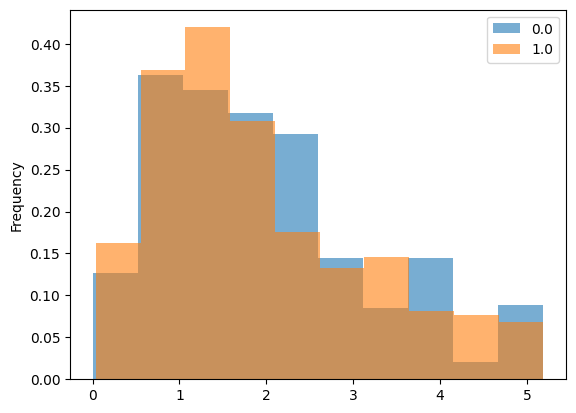

In [6]:
# There is no bias in "distvct" between control and treated in the dataset
data.groupby('any')['distvct'].plot(
    kind='hist',
    alpha=0.6,
    density=True,
    legend=True
)

any
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: age, dtype: object

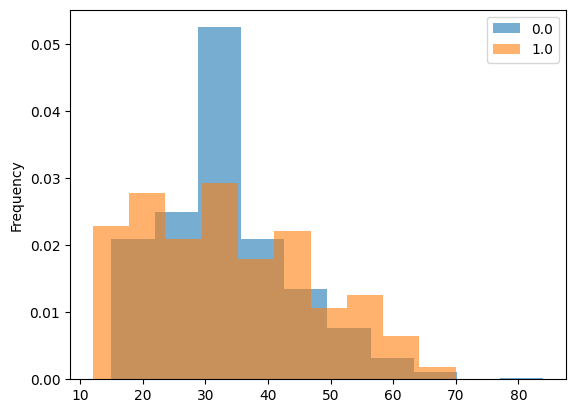

In [7]:
# There are some biases in "age" between control and treated in the dataset,
# which means that the samples are not fully randomized and we must be careful interpreting the result
data.groupby('any')['age'].plot(kind='hist', density=True, alpha=0.6, legend=True)

In [8]:
# Use the fixed features and the one in the optimization problem
features = ['tinc', 'distvct', 'age']
objective = 'got'

# Split the data into training and test
train, test = train_test_split(data, test_size=0.2, random_state=0)

# Make sure that the test data contains only the fixed features
test = test.drop(columns=['tinc', 'got'])

test.shape[0]

200

In [9]:
# Wrap StandardScaler to print messages when its methods and attributes are accessed
class StandardScaler(StandardScaler):
    def __getattribute__(self, name):
        attr = super().__getattribute__(name)
        if callable(attr):
            def new_func(*args, **kwargs):
                print(f'Calling StandardScaler.{name} method')
                result = attr(*args, **kwargs)
                return result
            return new_func
        else:
            print(f'Accessing StandardScaler.{name} attribute')
            return attr

# Use the wrapped StandardScaler
scaler = StandardScaler()

In [10]:
# Wrap LogisticRegression to print messages when its methods and attributes are accessed
class LogisticRegression(LogisticRegression):
    def __getattribute__(self, name):
        attr = super().__getattribute__(name)
        if callable(attr):
            def new_func(*args, **kwargs):
                print(f'Calling LogisticRegression.{name} method')
                result = attr(*args, **kwargs)
                return result
            return new_func
        else:
            print(f'Accessing LogisticRegression.{name} attribute')
            return attr

# Use the wrapped LogisticRegression
regression = LogisticRegression(random_state=1)

In [11]:
# Run the classification
pipe = make_pipeline(scaler, regression)
pipe.fit(X=train[features], y=train[objective])

Calling StandardScaler.fit_transform method
Calling StandardScaler.fit method
Calling StandardScaler._reset method
Calling StandardScaler.partial_fit method
Calling StandardScaler._validate_params method
Accessing StandardScaler._parameter_constraints attribute
Calling StandardScaler.get_params method
Calling StandardScaler._get_param_names method
Accessing StandardScaler.copy attribute
Accessing StandardScaler.with_mean attribute
Accessing StandardScaler.with_std attribute
Calling StandardScaler._validate_data method
Calling StandardScaler._check_feature_names method
Calling StandardScaler._check_n_features method
Accessing StandardScaler.with_std attribute
Accessing StandardScaler.with_mean attribute
Accessing StandardScaler.mean_ attribute
Accessing StandardScaler.var_ attribute
Accessing StandardScaler.n_samples_seen_ attribute
Accessing StandardScaler.n_samples_seen_ attribute
Accessing StandardScaler.n_samples_seen_ attribute
Accessing StandardScaler.with_std attribute
Accessing 

Pipeline(steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 new_func(C=1.0, class_weight=None, dual=False,
                          fit_intercept=True, intercept_scaling=1,
                          l1_ratio=None, max_iter=100, multi_class='auto',
                          n_jobs=None, penalty='l2', random_state=1,
                          solver='lbfgs', tol=0.0001, verbose=0,
                          warm_start=False))])

In [12]:
# Start with the normal part of creating a model
m = gp.Model()
y = gppd.add_vars(m, test, name='probability')

# Add a column to model the "tinc" feature
test = test.gppd.add_vars(m, lb=0.0, ub=3.0, name='tinc')
x = test['tinc']

# Make sure that the test data contains features in ther right order
test = test[features]

test.head()

Set parameter Username


,tinc,distvct,age
993,<gurobi.Var *Awaiting Model Update*>,2.144576,30.000000
859,<gurobi.Var *Awaiting Model Update*>,3.905001,25.000000
298,<gurobi.Var *Awaiting Model Update*>,2.306510,33.596472
553,<gurobi.Var *Awaiting Model Update*>,0.725098,23.000000
672,<gurobi.Var *Awaiting Model Update*>,3.821342,50.000000


In [13]:
# Calculate the budget of the total incentives
budget = 0.2 * test.shape[0]

# Add constraints to the model
m.setObjective(y.sum(), gp.GRB.MAXIMIZE)
m.addConstr(x.sum() <= budget)
m.update()

In [14]:
# Finally, add the constraints from the classsifier
pred_constr = add_predictor_constr(m, pipe, test, y, output_type="probability_1")
pred_constr.print_stats()

Accessing LogisticRegression.__dict__ attribute
Accessing StandardScaler.feature_names_in_ attribute
Accessing StandardScaler.n_features_in_ attribute
Accessing StandardScaler.n_features_in_ attribute
Accessing StandardScaler.n_features_in_ attribute
Accessing StandardScaler.n_features_in_ attribute
Accessing StandardScaler.n_features_in_ attribute
Accessing StandardScaler.__dict__ attribute
Accessing StandardScaler.scale_ attribute
Accessing StandardScaler.mean_ attribute
Accessing LogisticRegression.classes_ attribute
Accessing LogisticRegression.__dict__ attribute
Calling LogisticRegression._check_feature_names method
Accessing LogisticRegression.n_features_in_ attribute
Accessing LogisticRegression.n_features_in_ attribute
Accessing LogisticRegression.coef_ attribute
Accessing LogisticRegression.intercept_ attribute
Model for pipe1:
1200 variables
800 constraints
200 general constraints
Input has shape (200, 3)
Output has shape (200, 1)

Pipeline has 2 steps:

---------------------

In [15]:
# Optimize the problem
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 801 rows, 1600 columns and 2200 nonzeros
Model fingerprint: 0x12280613
Model has 200 general constraints
Variable types: 1600 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 7e+01]
  RHS range        [3e-01, 4e+01]
Presolve added 0 rows and 150 columns
Presolve removed 400 rows and 0 columns
Presolve time: 0.00s
Presolved: 401 rows, 1750 columns, 3300 nonzeros
Presolved model has 200 SOS constraint(s)
Variable types: 1750 continuous, 0 integer (0 binary)

Root relaxation: objective 5.941394e+01, 648 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0 

In [16]:
# Print error from the logistic regression prediction due to Gurobi's piecewise-linear approximation
print(
    "Maximum error in approximating the regression {:.6}".format(
        np.max(pred_constr.get_error())
    )
)

Calling StandardScaler.transform method
Accessing StandardScaler.__dict__ attribute
Accessing StandardScaler.copy attribute
Calling StandardScaler._validate_data method
Calling StandardScaler._check_feature_names method
Accessing StandardScaler.feature_names_in_ attribute
Calling StandardScaler._check_n_features method
Accessing StandardScaler.n_features_in_ attribute
Accessing StandardScaler.n_features_in_ attribute
Accessing StandardScaler.with_mean attribute
Accessing StandardScaler.mean_ attribute
Accessing StandardScaler.with_std attribute
Accessing StandardScaler.scale_ attribute
Calling LogisticRegression.predict_proba method
Accessing LogisticRegression.__dict__ attribute
Accessing LogisticRegression.multi_class attribute
Accessing LogisticRegression.multi_class attribute
Accessing LogisticRegression.classes_ attribute
Calling LogisticRegression.decision_function method
Accessing LogisticRegression.__dict__ attribute
Calling LogisticRegression._validate_data method
Calling Logi

In [17]:
# The variable "tinc" can go slightly negative due to Gurobi's piecewise-linear approximation,
# so apply floor_positive method to turn negative value 0 and round down small digits
def floor_positive(x):
    if x >= 0:
        return np.floor(x * 10 ** 5) / 10 ** 5
    else:
        return 0

tinc = pred_constr.input_values['tinc']
tinc = tinc.apply(floor_positive)

tinc.head()

993    0.0
859    0.0
298    0.0
553    0.0
672    0.0
Name: tinc, dtype: float64

In [18]:
# Finally, confirm the sum of all incentives is below the budget
tinc.sum() <= budget

True

# Conclusion

The integration of mathematical optimization and machine learning shows great promise for causal inference in specific use cases. While uplift modeling in machine learning is a common approach to causal inference, its naive implementation does not provide answers to the optimized treatment for each instance under constraints. For example, uplift modeling can identify who might recover from a disease with treatment, but it cannot determine whether to provide treatment under a limited budget.

To address this issue, integrating mathematical optimization and machine learning can provide solutions, and [Gurobi Machine Learning](https://gurobi-machinelearning.readthedocs.io/en/stable/) offers a range of tools to achieve this goal. However, it is important to note that the current limitation is that it only supports the logistic regression for classifiers in [scikit-learn](https://scikit-learn.org/stable/), which may not be sufficient for solving complex problems in the real world.

During the investigation, we discovered that [Gurobi Machine Learning](https://gurobi-machinelearning.readthedocs.io/en/stable/) does not adopt a black-box approach, instead simulating the machine learning model prediction through piecewise-linear approximation of the logistic regression for example. This is an intelligent approach, but it also implies that Gurobi needs to support each model individually, which can be time-consuming.

This feature is a recent addition to Gurobi, introduced in version 10.0, released in November 2022. We should remain updated in this field and watch for future developments.